## Notebook to push the identified donor IDs from demultiplexing back into the date

In [1]:
!date

Sat Jul 17 19:26:53 EDT 2021


#### import libraries and set notebook variables

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# parameters
cohort = 'aging'
pool_name = 'Aging_P003_SCRN_8'

In [4]:
# directories
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
expr_dir = f'{wrk_dir}/expression'
results_dir = f'{wrk_dir}/demux'
info_dir = f'{wrk_dir}/sample_info'

# in files
info_file = f'{info_dir}/{cohort}.pool_patient_sample_info.csv'
path_to_10x_h5 = f'{expr_dir}/{pool_name}.filtered_feature_bc_matrix.h5'

# out files
output_file = f'{results_dir}/{pool_name}.h5ad'

#### visualization functions

In [5]:
# function to plot the barcode counts by sample
def plot_sample_barcode_counts(this_df, sample_name, id_col='Sample_id'):
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")
    sns.barplot(x=this_df[id_col].value_counts().index, 
                y=this_df[id_col].value_counts().values, palette='Blues_d')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.title(sample_name)
    plt.ylabel('barcode counts')
    print(this_df[id_col].value_counts())

#### parse the pool name and look up the pool info

In [ ]:
def parse_pool_name(name):
    parts = name.split('_')
    # pool num 2nd item and lane num is 4th
    return parts[1], parts[3]

pool_num, lane_num = parse_pool_name(pool_name)
print(pool_num, lane_num)

# retrieve pool info
info_df = pd.read_csv(info_file)
# drop the un-needed columns
cols_to_drop = ['Pool_no', 'Sample_no', 'Sequence_type', 'Source_id']
info_df.drop(columns=cols_to_drop, inplace=True)
info_df = info_df.loc[info_df['pool_name'] == pool_num]
# add the lane number
info_df['lane_num'] = lane_num
print(info_df.shape)
# display(info_df)

#### load the 10X matrix files

In [7]:
%%time
adata = sc.read_10x_h5(path_to_10x_h5)
adata.var_names_make_unique()
    
print(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 7175 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
CPU times: user 1.07 s, sys: 79.1 ms, total: 1.15 s
Wall time: 1.15 s


#### load the demuxlet results

In [8]:
best_file = f'{results_dir}/{pool_name}.best'
demux_df = pd.read_csv(best_file, sep='\s+')
# set another best sample column and if doublet or ambigous set that as ID
demux_df['best_id'] = np.where(demux_df['DROPLET.TYPE'] == 'SNG', demux_df['SNG.BEST.GUESS'], 
                               np.where(demux_df['DROPLET.TYPE'] == 'DBL', 
                                        'doublet', 'ambiguous'))
print(demux_df.shape)    
# display(demux_df.sample(5))

(7174, 21)


#### merge other info with obs IDs

In [9]:
obs_id_df = demux_df[['best_id', 'BARCODE']].copy()
print(obs_id_df.shape)
# display(obs_id_df.head())
obs_id_df = obs_id_df.merge(info_df, how='left', 
                            left_on='best_id', right_on='donor_id')
print(obs_id_df.shape)
# display(obs_id_df.head())
# print(obs_id_df['Sample_id'].value_counts())
# print(obs_id_df['Tissue_source'].value_counts())
# print(obs_id_df['Brain_region'].value_counts())
# print(obs_id_df['Age'].describe())
# print(obs_id_df['Sex'].value_counts())

(7174, 2)
(7174, 11)


#### check that we aren't missing any barcodes

In [10]:
set(adata.obs) - set(demux_df['BARCODE'])

set()

#### index the demultiplexed IDs with the anndata obs barcodes

In [11]:
# obs_id_df = demux_df[['best_id', 'BARCODE']].copy()
obs_id_df.set_index('BARCODE', inplace=True)
obs_id_df = obs_id_df.reindex(adata.obs.index)
# fill any missing barcode IDs
obs_id_df['best_id'].fillna('unknown', inplace=True)
obs_id_df['donor_id'] = obs_id_df['best_id']
obs_id_df.drop(columns=['best_id'], inplace=True)
print(obs_id_df.shape)
# display(obs_id_df.head())

(7175, 9)


In [12]:
obs_id_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7175 entries, AAACCCAAGACTTCAC-1 to TTTGTTGCAGAACATA-1
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pool_name           5189 non-null   object 
 1   Sample_id           5189 non-null   object 
 2   Tissue_source       5189 non-null   object 
 3   Brain_region        5189 non-null   object 
 4   Clinical_diagnosis  5189 non-null   object 
 5   Age                 5189 non-null   float64
 6   Sex                 5189 non-null   object 
 7   donor_id            7175 non-null   object 
 8   lane_num            5189 non-null   object 
dtypes: float64(1), object(8)
memory usage: 818.6+ KB


#### add the sample info from demultiplexing to the obs

In [13]:
adata.obs = pd.concat([adata.obs, obs_id_df], axis='columns')

In [14]:
adata.obs['donor_id'].value_counts()

NHBCC-1604    1455
ambiguous     1099
NHBCC-1187    1088
doublet        865
NHBCC-1119     790
NHBCC-1669     631
NHBCC-1340     521
NHBCC-1275     370
NHBCC-2790     238
NHBCC-1137      96
NHBCC-1615       9
NHBCC-1556       4
NHBCC-831        3
NHBCC-2628       3
NHBCC-1613       2
unknown          1
Name: donor_id, dtype: int64

In [15]:
adata.obs['Sample_id'].value_counts()

Aging097    1455
Aging082    1088
Aging074     790
Aging109     631
Aging090     521
Aging086     370
Aging117     238
Aging078      96
Name: Sample_id, dtype: int64

#### visualize the counts by sample

Aging097    1455
Aging082    1088
Aging074     790
Aging109     631
Aging090     521
Aging086     370
Aging117     238
Aging078      96
Name: Sample_id, dtype: int64


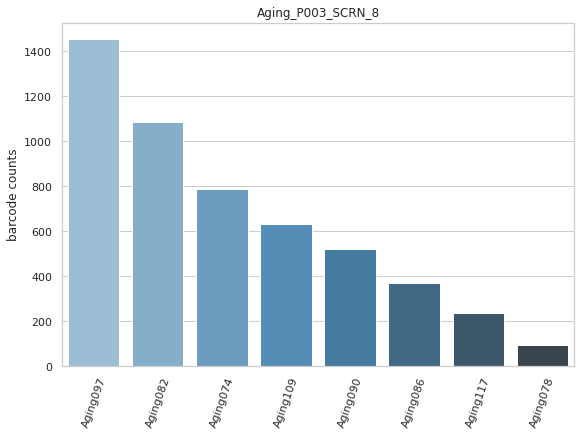

In [16]:
plot_sample_barcode_counts(adata.obs, pool_name)

NHBCC-1604    1455
ambiguous     1099
NHBCC-1187    1088
doublet        865
NHBCC-1119     790
NHBCC-1669     631
NHBCC-1340     521
NHBCC-1275     370
NHBCC-2790     238
NHBCC-1137      96
NHBCC-1615       9
NHBCC-1556       4
NHBCC-831        3
NHBCC-2628       3
NHBCC-1613       2
unknown          1
Name: donor_id, dtype: int64


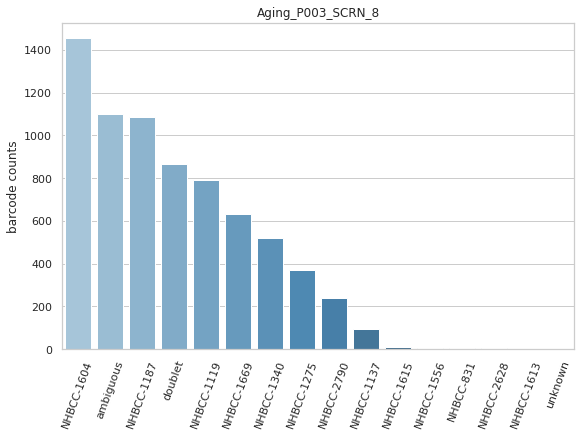

In [17]:
plot_sample_barcode_counts(adata.obs, pool_name, 'donor_id')

#### filter out the doublet, ambiguous, and unknowns

In [18]:
# filtd_adata = adata[~adata.obs['sample_id'].isin(['doublet', 'unknown'])]
# filtd_adata = adata[adata.obs['Sample_id'].isin(donor_list)].copy()
filtd_adata = adata[~adata.obs['Sample_id'].isna()].copy()
filtd_adata

AnnData object with n_obs × n_vars = 5189 × 36601
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num'
    var: 'gene_ids', 'feature_types', 'genome'

In [19]:
filtd_adata.obs['Sample_id'].value_counts()

Aging097    1455
Aging082    1088
Aging074     790
Aging109     631
Aging090     521
Aging086     370
Aging117     238
Aging078      96
Name: Sample_id, dtype: int64

In [20]:
filtd_adata.obs['donor_id'].value_counts()

NHBCC-1604    1455
NHBCC-1187    1088
NHBCC-1119     790
NHBCC-1669     631
NHBCC-1340     521
NHBCC-1275     370
NHBCC-2790     238
NHBCC-1137      96
Name: donor_id, dtype: int64

#### visualize the counts by sample again without the doublets and unknowns

Aging097    1455
Aging082    1088
Aging074     790
Aging109     631
Aging090     521
Aging086     370
Aging117     238
Aging078      96
Name: Sample_id, dtype: int64


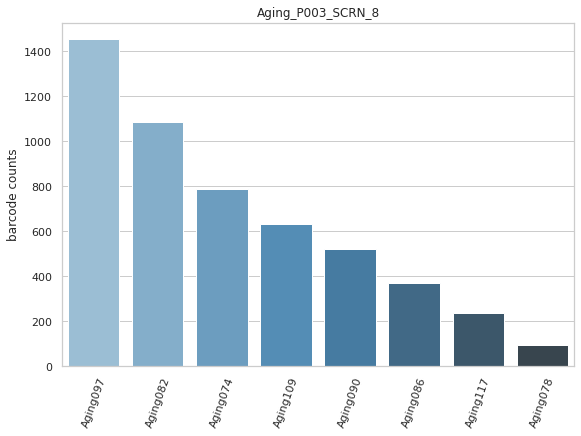

In [21]:
plot_sample_barcode_counts(filtd_adata.obs, pool_name)

NHBCC-1604    1455
NHBCC-1187    1088
NHBCC-1119     790
NHBCC-1669     631
NHBCC-1340     521
NHBCC-1275     370
NHBCC-2790     238
NHBCC-1137      96
Name: donor_id, dtype: int64


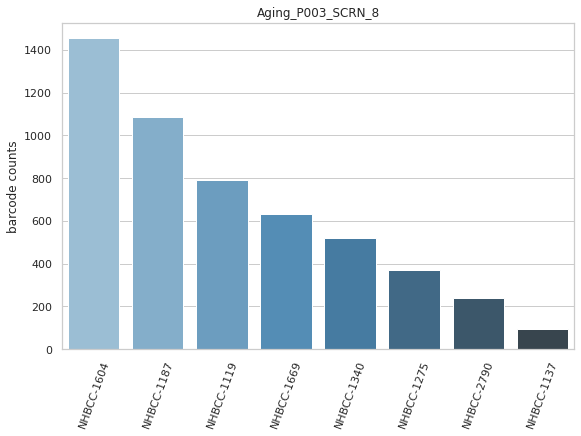

In [22]:
plot_sample_barcode_counts(filtd_adata.obs, pool_name, 'donor_id')

#### save the modified anndata object

In [23]:
filtd_adata.write(output_file)

... storing 'pool_name' as categorical
... storing 'Sample_id' as categorical
... storing 'Tissue_source' as categorical
... storing 'Brain_region' as categorical
... storing 'Clinical_diagnosis' as categorical
... storing 'Sex' as categorical
... storing 'donor_id' as categorical
... storing 'lane_num' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [24]:
filtd_adata

AnnData object with n_obs × n_vars = 5189 × 36601
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num'
    var: 'gene_ids', 'feature_types', 'genome'